In [1]:
import psycopg2
from psycopg2.extras import DictCursor
import os
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
sql_host = '10.129.0.25'

In [3]:
!env | grep POST

POSTGRESQL_USER=reader
POSTGRESQL_PASSWORD=Miba2021


In [4]:
def get_query(query: int):
    with psycopg2.connect(
        dbname = 'demo',
        user = os.environ['POSTGRESQL_USER'],
        password = os.environ['POSTGRESQL_PASSWORD'],
        host = sql_host
    )as c:
        with c.cursor() as cur:
            cur.execute(query)
            res = cur.fetchall()
            return res

In [14]:
# The name of the passenger with the ticket number '0005432312164'
res = get_query("SELECT passenger_name FROM tickets WHERE ticket_no = '0005432312164'")
print(f'The name of the passenger is {res[0][0]}')

The name of the passenger is ALEKSEY GERASIMOV


In [7]:
res = get_query("SELECT passenger_id FROM tickets WHERE ticket_no = '0005432312164'")
res

[('0423 646487',)]

In [10]:
# Let's find all the available information about this passenger
query = "SELECT book_date, fare_conditions, t.ticket_no, departure_airport, arrival_airport, \
                actual_departure, actual_arrival, a1.city AS arrival_city,\
                a2.city as departure_city, passenger_id, f.flight_id\
         FROM bookings b \
         JOIN tickets t ON t.book_ref = b.book_ref \
         JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no \
         JOIN flights f ON f.flight_id = tf.flight_id \
         JOIN airports a1 ON a1.airport_code  = f.arrival_airport \
         JOIN airports a2 ON a2.airport_code = f.departure_airport \
         WHERE t.passenger_id = '0423 646487'"
data = (get_query(query))

In [11]:
df = pd.DataFrame(data, columns = ['booking_date', 'fare_conditions', 'ticket_no', 'departure_airport', 
                                   'arrival_airport','departure_dt', 'arrival_dt','arrival_city',
                                   'departure_city', 'passenger_id','flight_id'])

In [12]:
df

,booking_date,fare_conditions,ticket_no,departure_airport,arrival_airport,departure_dt,arrival_dt,arrival_city,departure_city,passenger_id,flight_id
0,2016-07-28 07:24:00+00:00,Economy,0005432312164,DME,EGO,2016-08-15 16:55:00+00:00,2016-08-15 17:40:00+00:00,Belgorod,Moscow,0423 646487,19976
1,2016-07-28 07:24:00+00:00,Economy,0005432312164,EGO,DME,2016-08-24 12:31:00+00:00,2016-08-24 13:17:00+00:00,Moscow,Belgorod,0423 646487,202076
2,2016-07-28 07:24:00+00:00,Economy,0005432312164,EGO,AAQ,2016-08-16 10:03:00+00:00,2016-08-16 10:54:00+00:00,Anapa,Belgorod,0423 646487,202563
3,2016-07-28 07:24:00+00:00,Economy,0005432312164,AAQ,EGO,2016-08-24 09:26:00+00:00,2016-08-24 10:16:00+00:00,Belgorod,Anapa,0423 646487,136916


In [13]:
print(f"A.Gerasimov made {df['flight_id'].nunique()} flights")

A.Gerasimov made 4 flights


In [11]:
passengers = get_query("SELECT passenger_id FROM tickets LIMIT 1000")


In [12]:
from tqdm import tqdm
def get_passenger(id):
    query = f"SELECT book_date, fare_conditions, t.ticket_no, departure_airport, arrival_airport, \
                actual_departure, actual_arrival, a1.city AS arrival_city,\
                a2.city as departure_city, passenger_id, f.flight_id\
         FROM bookings b \
         JOIN tickets t ON t.book_ref = b.book_ref \
         JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no \
         JOIN flights f ON f.flight_id = tf.flight_id \
         JOIN airports a1 ON a1.airport_code  = f.arrival_airport \
         JOIN airports a2 ON a2.airport_code = f.departure_airport \
         WHERE t.passenger_id = '{id}'"
    return get_query(query)
all_pgrs = []
for i in tqdm(passengers):
    data = get_passenger(i[0])
    all_pgrs.append(data)

100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]


In [13]:
flat_data = [item for sublist in all_pgrs for item in sublist]

In [14]:
df = pd.DataFrame(flat_data, columns = ['booking_date', 'fare_conditions', 'ticket_no', 'departure_airport', 
                                   'arrival_airport','departure_dt', 'arrival_dt','arrival_city',
                                   'departure_city', 'passenger_id','flight_id'])
df.head()

,booking_date,fare_conditions,ticket_no,departure_airport,arrival_airport,departure_dt,arrival_dt,arrival_city,departure_city,passenger_id,flight_id
0,2017-02-02 07:35:00+00:00,Business,0005432207214,DME,LED,2017-02-16 06:40:00+00:00,2017-02-16 07:34:00+00:00,St. Petersburg,Moscow,5815 588146,307
1,2017-02-02 07:35:00+00:00,Business,0005432207214,KRR,DME,2017-02-15 15:00:00+00:00,2017-02-15 16:30:00+00:00,Moscow,Krasnodar,5815 588146,156341
2,2017-02-02 22:09:00+00:00,Business,0005432207215,DME,LED,2017-02-16 06:40:00+00:00,2017-02-16 07:34:00+00:00,St. Petersburg,Moscow,0129 214665,307
3,2017-02-02 22:09:00+00:00,Economy,0005432207215,KRR,DME,2017-02-15 15:00:00+00:00,2017-02-15 16:30:00+00:00,Moscow,Krasnodar,0129 214665,156341
4,2017-01-30 15:16:00+00:00,Economy,0005432207217,DME,LED,2017-02-17 06:37:00+00:00,2017-02-17 07:32:00+00:00,St. Petersburg,Moscow,4175 459220,238


In [17]:
query = "SELECT book_date, fare_conditions, t.ticket_no, departure_airport, arrival_airport, \
                actual_departure, actual_arrival, a1.city AS arrival_city,\
                a2.city as departure_city, passenger_id, f.flight_id\
         FROM bookings b \
         JOIN tickets t ON t.book_ref = b.book_ref \
         JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no \
         JOIN flights f ON f.flight_id = tf.flight_id \
         JOIN airports a1 ON a1.airport_code  = f.arrival_airport \
         JOIN airports a2 ON a2.airport_code = f.departure_airport \
         LIMIT 1500000"
data = get_query(query)

In [18]:
df = pd.DataFrame(data, columns = ['booking_date', 'fare_conditions', 'ticket_no', 'departure_airport', 
                                   'arrival_airport','departure_dt', 'arrival_dt','arrival_city',
                                   'departure_city', 'passenger_id','flight_id'])
df.shape

(1500000, 11)

In [41]:
top_10 = df['arrival_city'].value_counts().nlargest(10).reset_index()
top_10.columns = ['arrival_city', 'count']

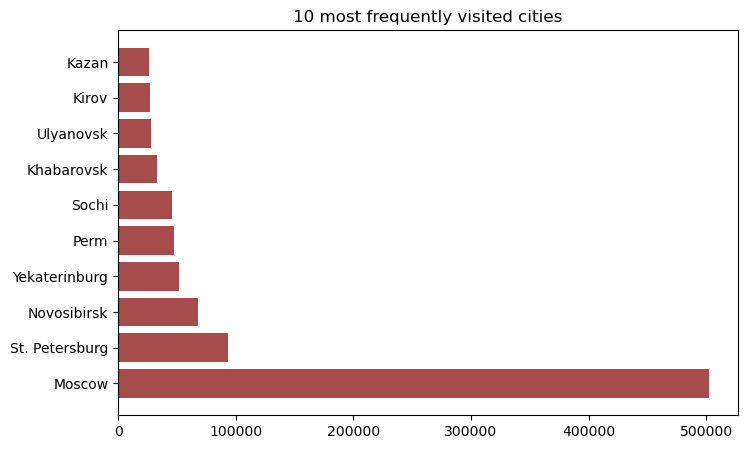

In [42]:
plt.figure(figsize = (8,5))
plt.barh(top_10['arrival_city'], top_10['count'], color = 'maroon', alpha = .7)
plt.title('10 most frequently visited cities')
plt.show()

In [44]:
top_10_d = df['departure_city'].value_counts().nlargest(10).reset_index()
top_10_d.columns = ['departure_city', 'count']

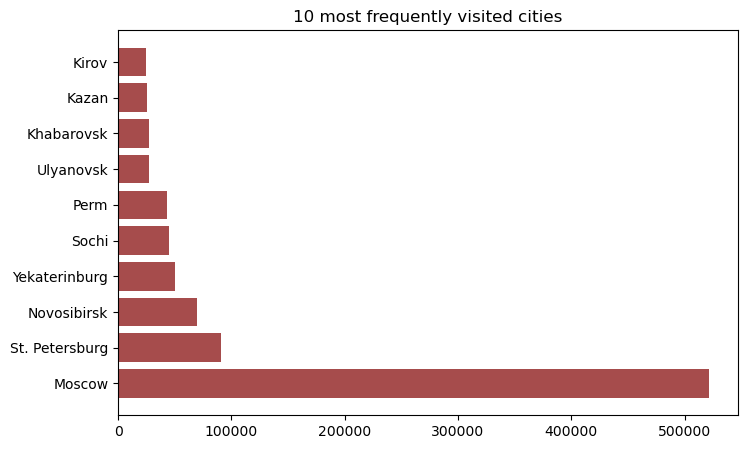

In [45]:
plt.figure(figsize = (8,5))
plt.barh(top_10_d['departure_city'], top_10_d['count'], color = 'maroon', alpha = .7)
plt.title('10 most frequently visited cities')
plt.show()

In [62]:
max(df['booking_date'])

Timestamp('2017-08-14 20:49:00+0000', tz='UTC')

In [57]:
min(df['booking_date'])

Timestamp('2016-07-27 16:26:00+0000', tz='UTC')

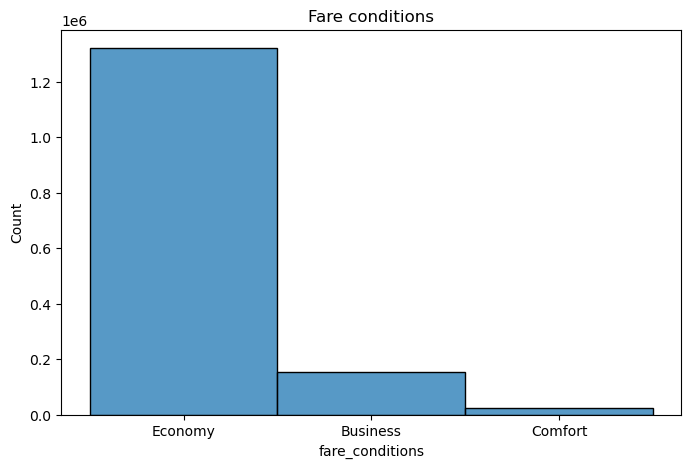

In [21]:
fig = plt.figure(figsize = (8,5))
sns.histplot(df, x = 'fare_conditions')
plt.title('Fare conditions')
plt.show()

In [22]:
df['month_year'] = df['departure_dt'].dt.strftime('%m-%Y')
df.head()

,booking_date,fare_conditions,ticket_no,departure_airport,arrival_airport,departure_dt,arrival_dt,arrival_city,departure_city,passenger_id,flight_id,month_year
0,2016-11-16 22:11:00+00:00,Economy,0005432594632,NNM,ARH,2016-12-04 11:17:00+00:00,2016-12-04 12:11:00+00:00,Arkhangelsk,Naryan-Mar,2980 107686,139158,12-2016
1,2016-10-07 22:41:00+00:00,Economy,0005434970992,UUA,REN,2016-10-21 08:00:00+00:00,2016-10-21 08:30:00+00:00,Orenburg,Bugulma,7973 699803,153489,10-2016
2,2016-10-19 08:32:00+00:00,Economy,0005433530233,NUX,HTA,2016-11-04 04:55:00+00:00,2016-11-04 08:37:00+00:00,Chita,Novy Urengoy,6284 813451,123067,11-2016
3,2016-10-29 18:20:00+00:00,Economy,0005435930592,VKO,SLY,2016-11-21 07:58:00+00:00,2016-11-21 10:49:00+00:00,Salekhard,Moscow,8327 648746,25400,11-2016
4,2016-09-09 20:19:00+00:00,Economy,0005434321935,MMK,VKO,2016-09-30 11:06:00+00:00,2016-09-30 13:12:00+00:00,Moscow,Murmansk,5310 451734,101466,09-2016


In [34]:
from datetime import datetime
stata = df.groupby('month_year')['ticket_no'].count().reset_index()
stata.columns = ['month_year', 'count']
stata['month_year'] = stata['month_year'].astype('str')
stata['date'] = stata['month_year'].apply(lambda x: datetime.strptime(x,'%m-%Y'))
stata.sort_values(by = 'date', inplace = True)
stata.reset_index(drop = True, inplace = True)

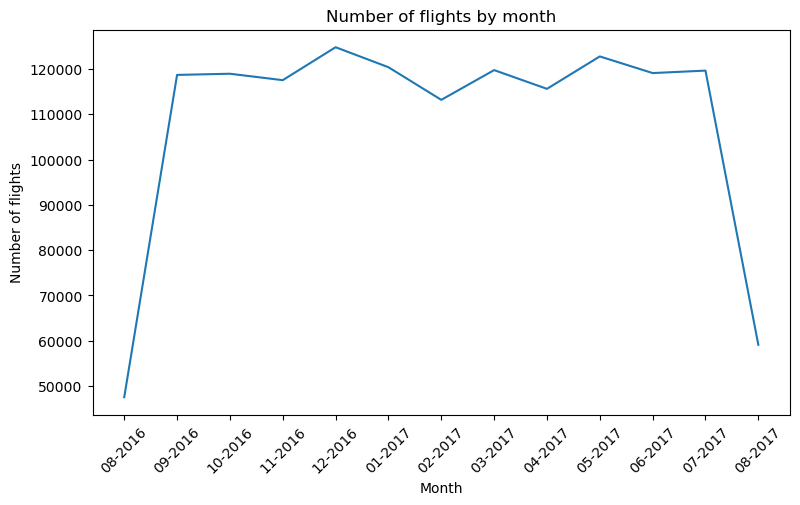

In [26]:
plt.figure(figsize = (9,5))
plt.plot(stata['month_year'], stata['count'])
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Number of flights')
plt.title('Number of flights by month')
plt.show()

In [36]:
stata = stata[1:-1]

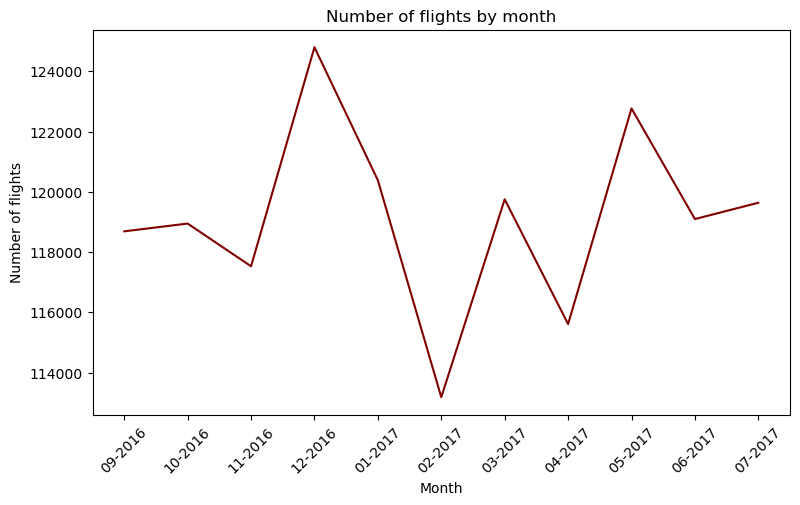

In [51]:
plt.figure(figsize = (9,5))
plt.plot(stata['month_year'], stata['count'], color = 'maroon')
plt.xticks(rotation = 45)
plt.xlabel('Month')
plt.ylabel('Number of flights')
plt.title('Number of flights by month')
plt.show()

In [50]:
df['arrival_city'].value_counts()[3] / len(df)

0.034552